## Term Deposit Marketing

### Background:

We are interested in developing a robust machine learning system that leverages information coming from call centers. We are looking for ways to improve the success rate for calls made to customers for any product that our clients offer.

### Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

- `age`: age of customer (numeric) </br>
- `job` - type of job (categorical) </br>
- `marital` - marital status (categorical) </br>
- `education` - (categorical) </br>
- `default` - has credit in default? (binary) </br>
- `balance` - average yearly balance, in euros (numeric) </br>
- `housing` - has a housing loan? (binary) </br>
- `loan` - has personal loan? (binary) </br>
- `contact` - contact communication type (categorical) </br>
- `day` - last contact day of the month (numeric) </br>
- `month` - last contact month of year (categorical) </br>
- `duration` - last contact duration, in seconds (numeric) </br>
- `campaign` - number of contacts performed during this campaign and for this client (numeric, includes last contact) </br>


### Output (desired target):

`y` - has the client subscribed to a term deposit? (binary)


### Goal:

Predict if the customer will subscribe (yes/no) to a term deposit. Hit 81 % or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score. Determine which features are relevant to finding out customers who are more likely to subscribe.

### Importing Modules and Data

In [1]:
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classification algorithms
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
import xgboost

from imblearn.over_sampling import SMOTE

# Model evaluation metrics
from sklearn.metrics import (classification_report, accuracy_score, roc_curve, roc_auc_score, 
f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay)

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


Dataset contains 40000 rows with no null values.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [5]:
categorical_features = ['job', 'marital', 'education', 'contact']
numerical_features = ['age', 'duration', 'balance', 'campaign']
binary_features = ['default', 'housing', 'loan', 'y']
day_features = ['day', 'month']

# Helper Functions
sns.set_theme(rc={'figure.figsize':(10, 10)})
def plot_hist(column_name, dataframe, y):
    df_plot = df.groupby([column_name, y]).size().reset_index().pivot(columns=column_name, index=y, values=0)
    df_plot.plot(kind='bar', stacked=True)
    plt.title(column_name.title(), fontsize = 15)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.xticks(rotation=30)
    plt.show()
    
def plot_box(column_name, dataframe):
    sns.boxplot(y=column_name, x="y", hue="y", data=dataframe, dodge=False, width=0.4)
    plt.legend(loc="upper left")
    plt.title(column_name.title(), fontsize = 15)
    plt.xlabel("Labels")
    plt.xticks(rotation=30)
    plt.show()
    
def eval_results(actual, predictions, model):
    # F1 Score
    print("F1 Score: ", f1_score(actual, predictions))
    
    # Visualize the evaluation report
    print(classification_report(actual, predictions))
    
    # Plot the confusion matrix
    cm = confusion_matrix(actual, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    print("Total predictions for class 0: ", np.bincount(predictions)[0])
    print("Total predictions for class 1: ", np.bincount(predictions)[1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth= 2, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

### Data Visualization and EDA

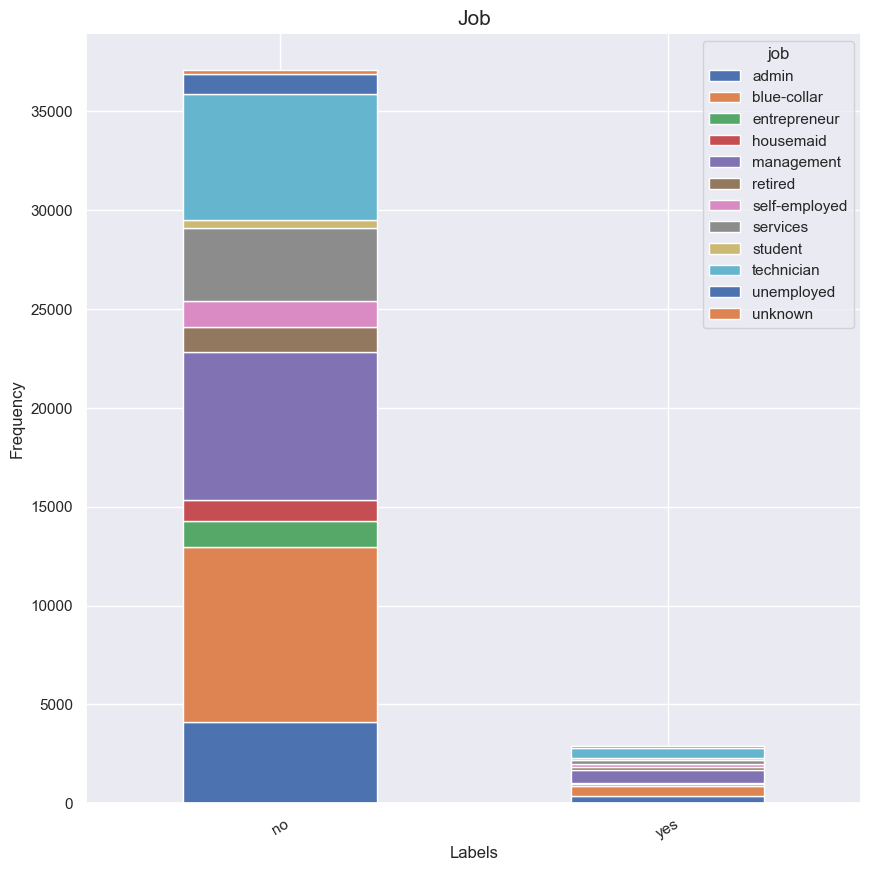

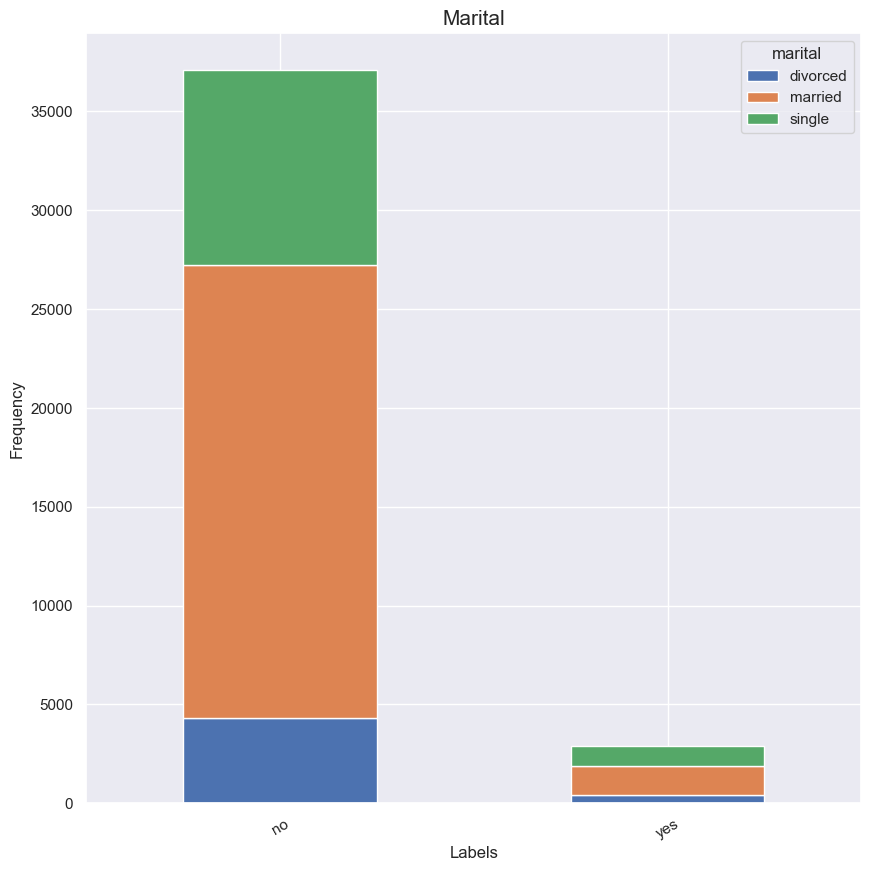

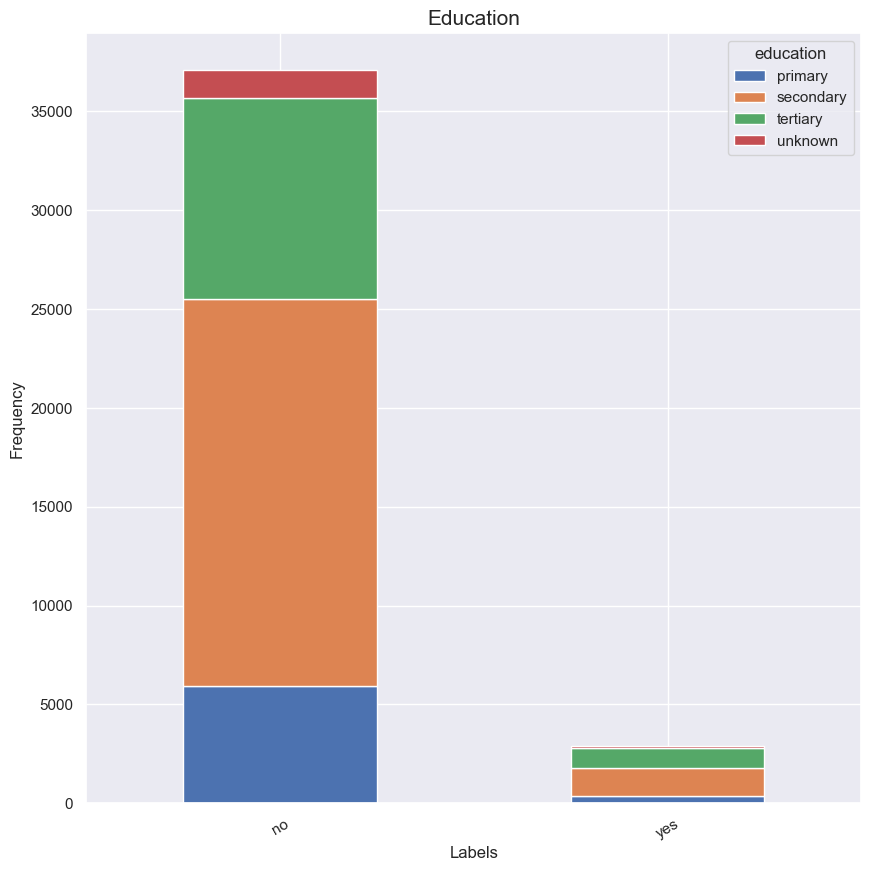

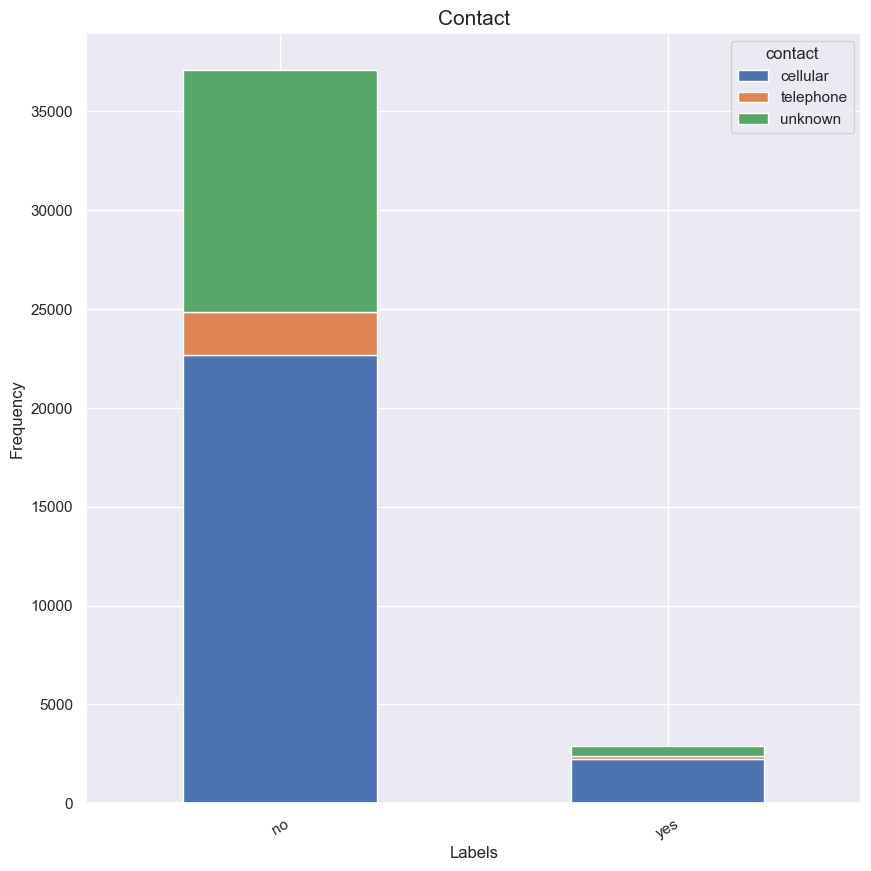

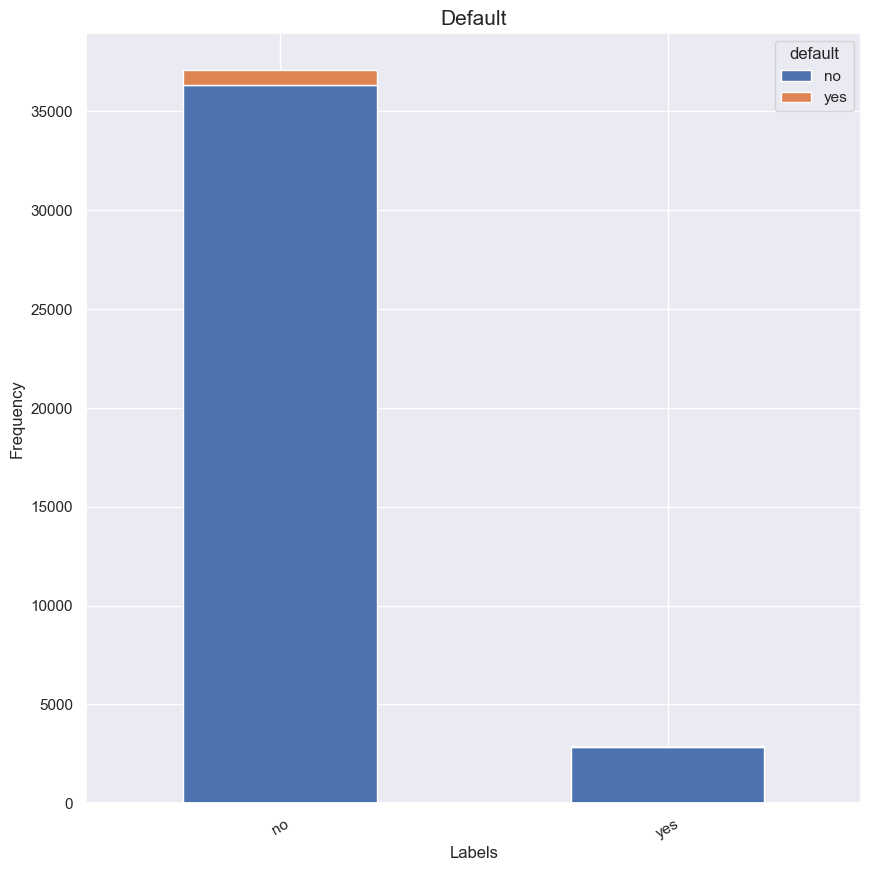

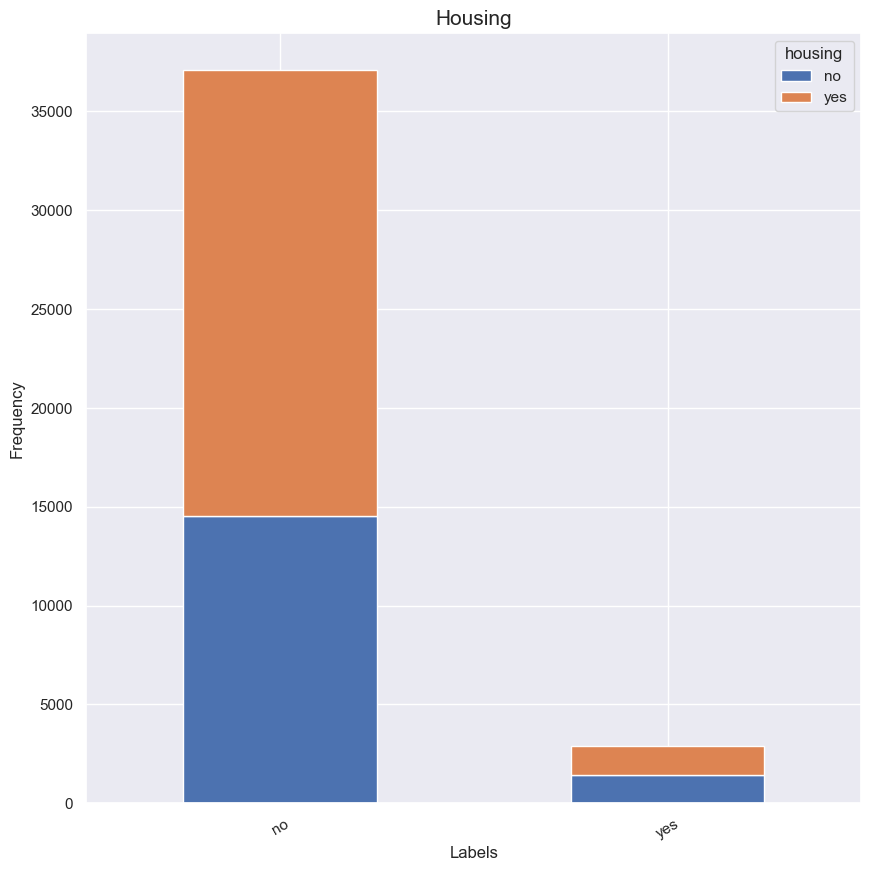

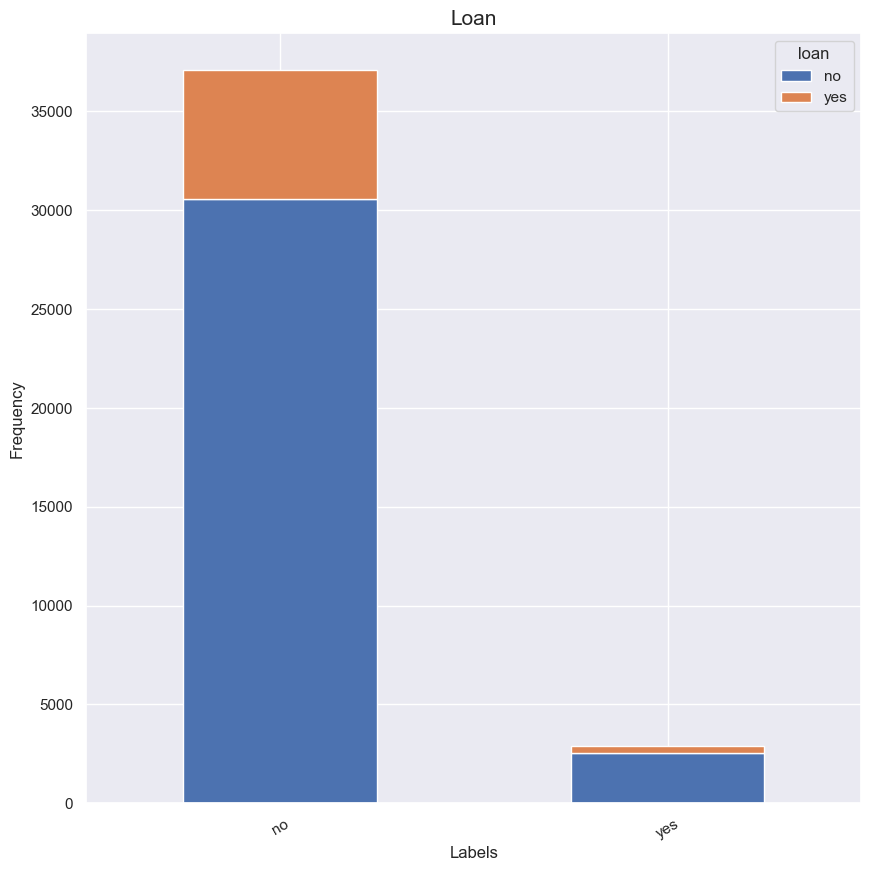

In [6]:
for i in (categorical_features + binary_features):
    if i != 'y':
        plot_hist(i, df, 'y')

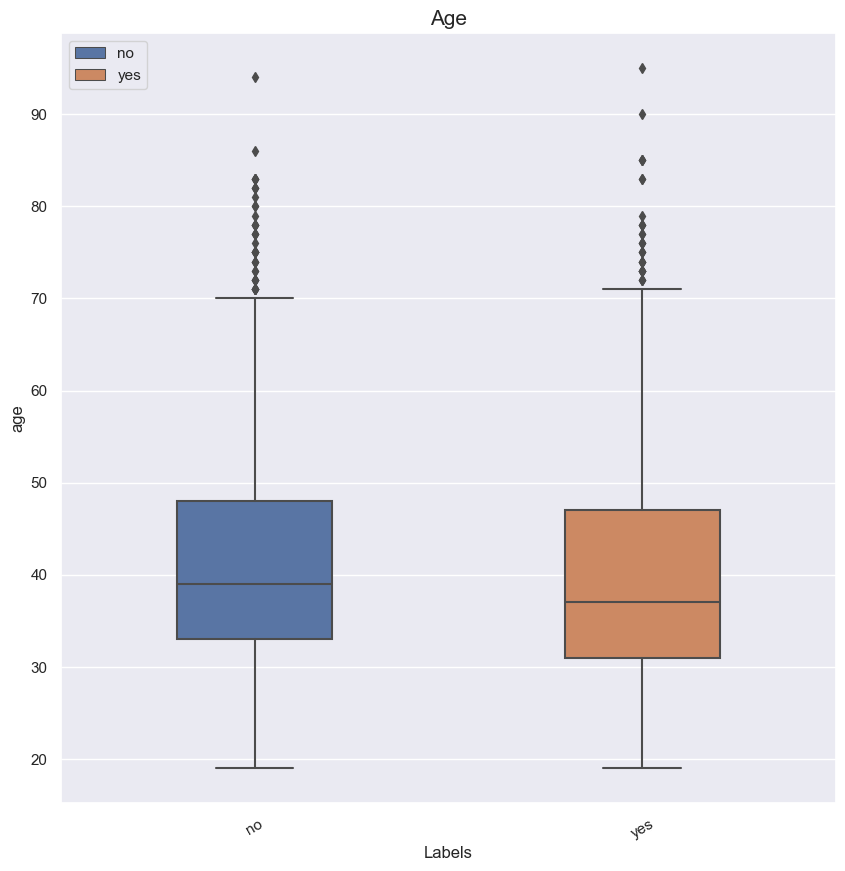

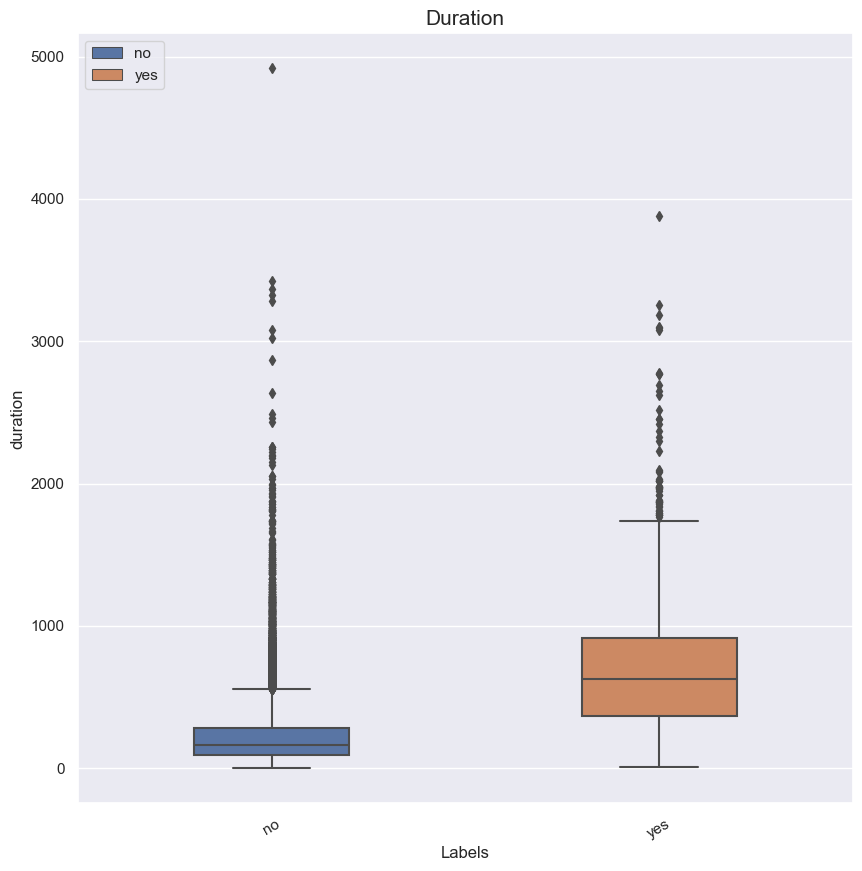

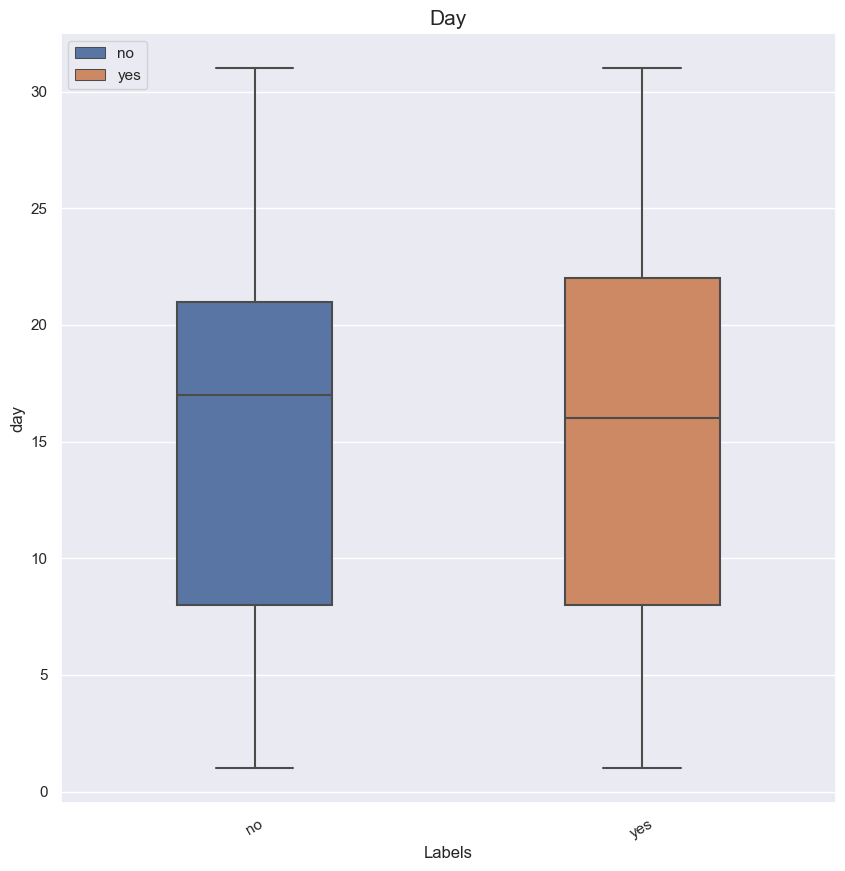

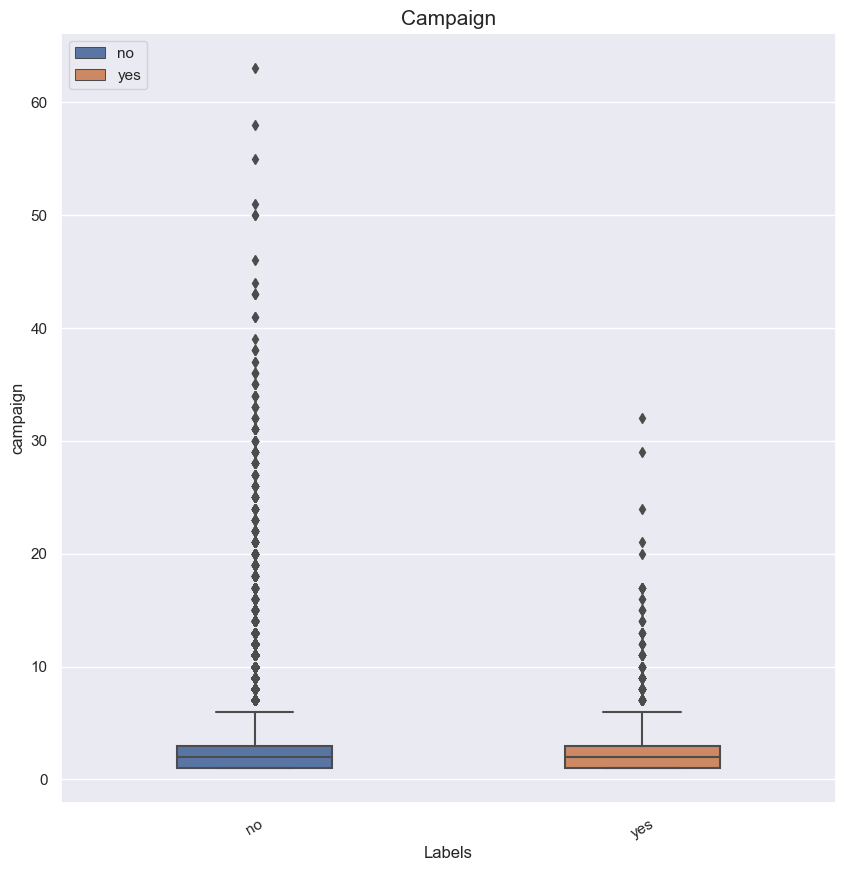

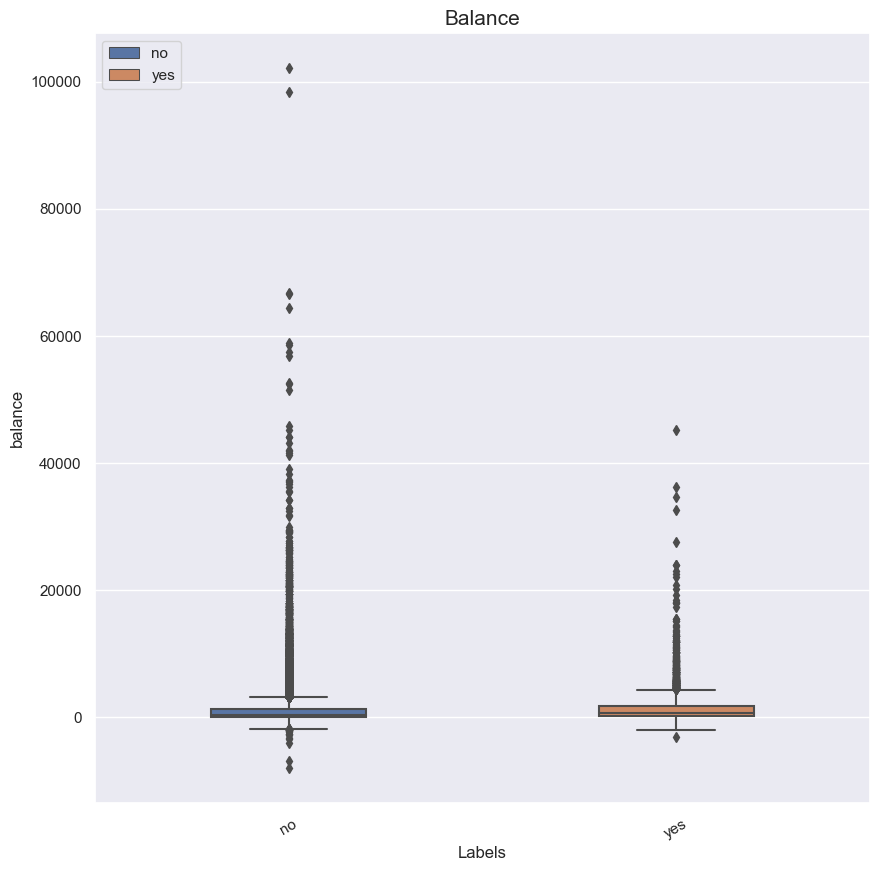

In [7]:
plot_box("age", df)
plot_box("duration", df)
plot_box("day", df)
plot_box("campaign", df)
plot_box("balance", df)

**Age:** People between the ages 30 to 38 are more likely to subscribe. Additionally, older age group people (60+) can be targeted to understand their behaviour.

**Default:** From the plot we can observe that default feature will not be a good predictor as it is highly imbalanced. 

**Balance:** People with higher balance are more likely to subscribe. We can observe that there are large number of people with zero balance probably indicating no account. Hence, people with 0 balance are likely to subscribe.

**Housing:** The distribution of people likely or not likely to subscribe is roughly the same irrespective of whether they have a housing loan or not.

**Loan:** Similar to default, loan is not a good predictor.

**Job:** Management levels and Blue Collars are more likely to subscribe and other job levels are less likely to subscribe.

**Marital:** Single people are more likely and Married people are less likely to subscribe.

**Education:** People with tertiary education are more likely to subscribe.


### Data Preparartion

We will convert the raw data into a datset such that it can be used to build a machine learning solution. The dataset contains categorical, numerical and datetime features. We will perform one hot encoding on categorical features, binary features are numerically encoded and datetime features are cyclically encoded. Additionally, we wil also perform standardization on the dataset. Furthermore, dataset is highly imbalanced as seen in the following figure. We will perform SMOTE to increase the size of our training data to ensure the training data is not imbalanced. We will perform SMOTE before we split our dataset into train and test data to ensure there is no data leakage.

That dataset contains 37104 examples belonging to class 0 and 2896 examples belonging to class 1


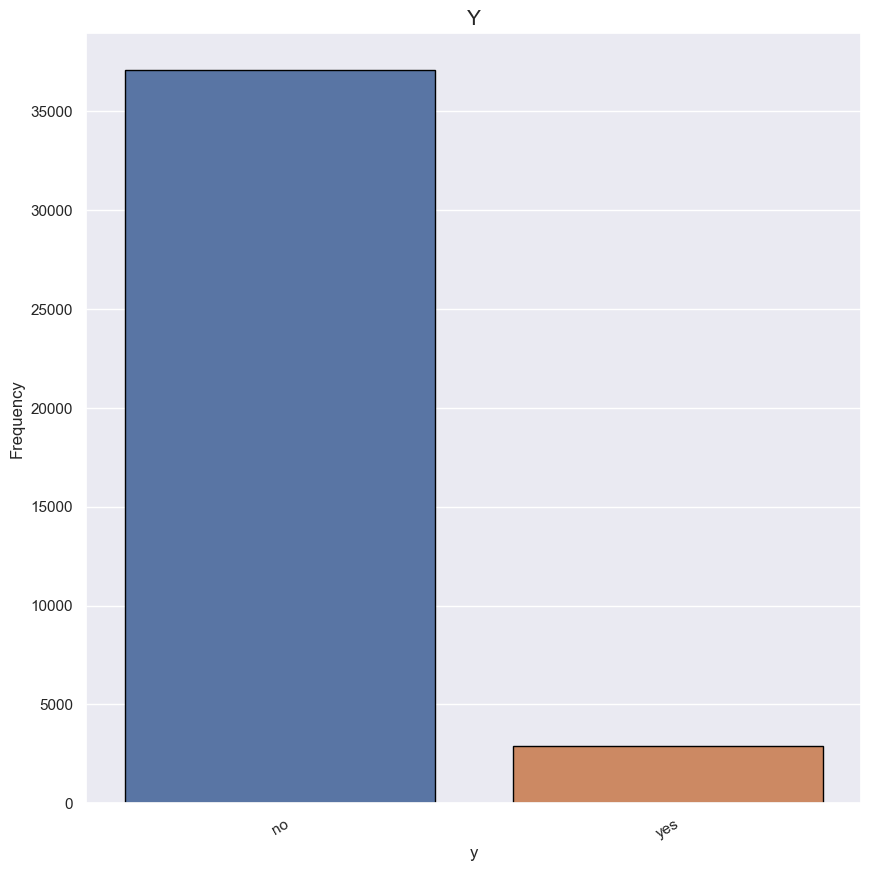

In [8]:
print("That dataset contains {} examples belonging to class 0 and {} examples belonging to class 1".
      format(df.y.value_counts()[0], df.y.value_counts()[1]))

sns.countplot(x='y', data=df, edgecolor="black")
plt.title('y'.title(), fontsize = 15)
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.show()

As mentioned above, data is imbalanced and a single class is over represented. We will perform oversampling to ensure the final model is trained on balanced data and avoid generalization errors.

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [9]:
# Perfrom various types of encoding on the data.

month_dict = {'jan': 1,
              'feb': 2,
              'mar': 3,
              'apr':4,
              'may':5,
              'jun':6,
              'jul':7,
              'aug':8,
              'sep':9,
              'oct':10,
              'nov':11,
              'dec':12
             }


for i in categorical_features:
    df = pd.get_dummies(df, columns=[i], dtype='int16')

for i in binary_features:
    df[i] = np.where(df[i] == 'yes', 1, 0)

df['month'].replace(month_dict, inplace=True)

def day_transformation(column):
    max_value = column.max()
    sin_values = [np.sin((2*np.pi*x)/max_value) for x in list(column)]
    cos_values = [np.cos((2*np.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

df["day_sin"], df["day_cos"] = day_transformation(df["day"])

df.head()

,age,default,balance,housing,loan,day,month,duration,campaign,y,...,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,day_sin,day_cos
0,58,0,2143,1,0,5,5,261,1,0,...,0,0,0,1,0,0,0,1,0.848644,0.528964
1,44,0,29,1,0,5,5,151,1,0,...,1,0,1,0,0,0,0,1,0.848644,0.528964
2,33,0,2,1,1,5,5,76,1,0,...,0,0,1,0,0,0,0,1,0.848644,0.528964
3,47,0,1506,1,0,5,5,92,1,0,...,0,0,0,0,1,0,0,1,0.848644,0.528964
4,33,0,1,0,0,5,5,198,1,0,...,1,0,0,0,1,0,0,1,0.848644,0.528964


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  40000 non-null  int64  
 1   default              40000 non-null  int32  
 2   balance              40000 non-null  int64  
 3   housing              40000 non-null  int32  
 4   loan                 40000 non-null  int32  
 5   day                  40000 non-null  int64  
 6   month                40000 non-null  int64  
 7   duration             40000 non-null  int64  
 8   campaign             40000 non-null  int64  
 9   y                    40000 non-null  int32  
 10  job_admin            40000 non-null  int16  
 11  job_blue-collar      40000 non-null  int16  
 12  job_entrepreneur     40000 non-null  int16  
 13  job_housemaid        40000 non-null  int16  
 14  job_management       40000 non-null  int16  
 15  job_retired          40000 non-null 

After encoding, the total number of features has increased to 33.

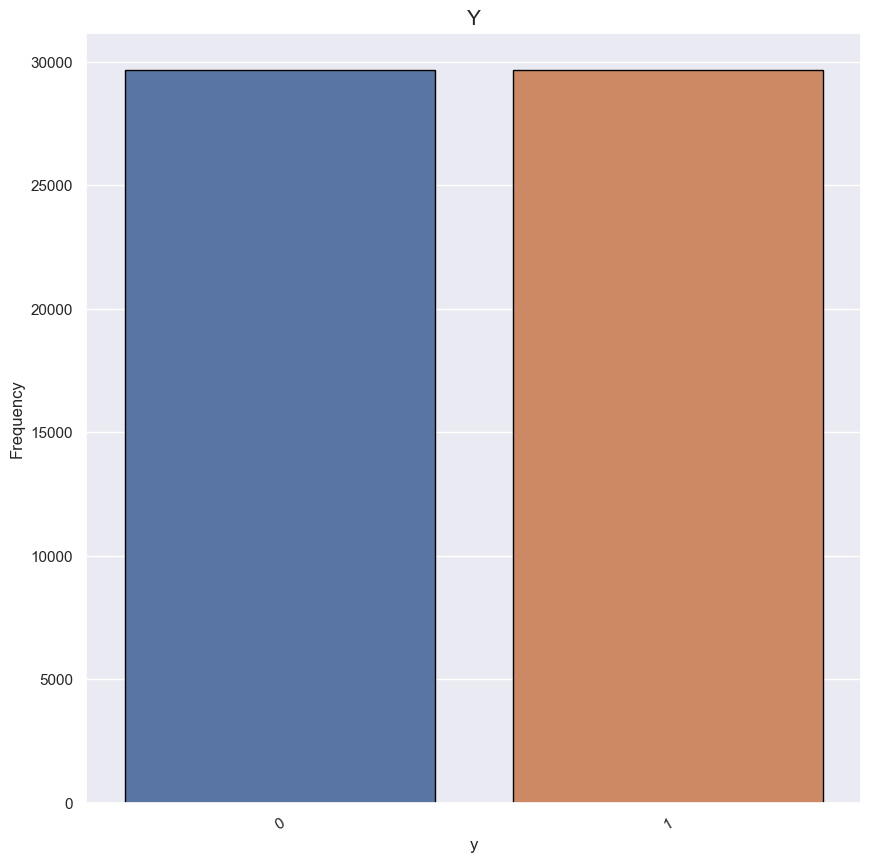

Training data distribution
 0    29683
1    29683
Name: y, dtype: int64
Training data Shape:  (59366, 32)
Test data distribution
 0    7421
1     579
Name: y, dtype: int64
Test data Shape:  (8000, 32)


In [11]:
# Dataset is divided into training (80%) and test dataset (20%).

#data = df[['duration', 'campaign', 'contact_cellular', 'month', 'contact_unknown',  'balance', 'day', 'marital_married', 'housing', 'marital_single', 'age']]
data = df.drop(['y', 'day'], axis=1)
target = df['y']

# We use stratified splitting to ensure the ratio of classess is maintained in both test and training data.
X_train1, X_test1, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train1)
X_train  =scaler.transform(X_train1)
X_test =scaler.transform(X_test1)


oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

sns.countplot(x='y', data=y_train_smote.to_frame(), edgecolor="black")
plt.title('y'.title(), fontsize = 15)
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.show()

print("Training data distribution\n", y_train_smote.value_counts())
print("Training data Shape: ", X_train_smote.shape)
print("Test data distribution\n", y_test.value_counts())
print("Test data Shape: ", X_test.shape)

The training data is now balanced and test data is representative of the original dataset.

In [12]:
# In this section we will use pycaret library to summarize the performance of various classification algorithms on the dataset.
# We will select the best performing models to build a solution.

a = pd.DataFrame(X_train_smote)
b = pd.DataFrame(y_train_smote)

c = pd.DataFrame(X_test)
d = pd.DataFrame(y_test)

new_df = pd.concat([a, b], axis=1)
test_df = pd.concat([c.reset_index(drop=True), d.reset_index(drop=True)], axis=1)

from pycaret.classification import *

s = setup(data=new_df, target='y', session_id=42, test_data=test_df)

,Description,Value
0,Session id,42
1,Target,y
2,Target type,Binary
3,Original data shape,"(67366, 33)"
4,Transformed data shape,"(83366, 33)"
5,Transformed train set shape,"(67366, 33)"
6,Transformed test set shape,"(16000, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


In [13]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9744,0.9975,0.9826,0.9615,0.9712,0.9482,0.9494,4.5160
rf,Random Forest Classifier,0.9623,0.9966,0.9636,0.9534,0.9551,0.9230,0.9270,2.9530
xgboost,Extreme Gradient Boosting,0.9431,0.9940,0.9105,0.9622,0.9023,0.8780,0.8914,5.4630
knn,K Neighbors Classifier,0.9411,0.9783,0.9896,0.8913,0.9377,0.8821,0.8867,1.9260
lightgbm,Light Gradient Boosting Machine,0.9399,0.9942,0.9089,0.9562,0.9014,0.8721,0.8853,0.8300
dt,Decision Tree Classifier,0.9336,0.9330,0.9268,0.9251,0.9193,0.8641,0.8702,0.2800
gbc,Gradient Boosting Classifier,0.9313,0.9861,0.9339,0.9146,0.9210,0.8605,0.8643,5.4190
ada,Ada Boost Classifier,0.9109,0.9716,0.9026,0.8987,0.8978,0.8191,0.8221,1.6280
lr,Logistic Regression,0.8420,0.9211,0.8026,0.8389,0.8202,0.6795,0.6801,1.2070
svm,SVM - Linear Kernel,0.8397,0.0000,0.8091,0.8300,0.8193,0.6753,0.6757,0.5530


In [14]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9737,0.9974,0.9831,0.9595,0.9708,0.9469,0.9476,3.3180
rf,Random Forest Classifier,0.9602,0.9963,0.9625,0.9504,0.9547,0.9193,0.9219,2.7220
xgboost,Extreme Gradient Boosting,0.9433,0.9941,0.9106,0.9644,0.9250,0.8822,0.8942,3.2080
lightgbm,Light Gradient Boosting Machine,0.9399,0.9943,0.9082,0.9592,0.9215,0.8753,0.8871,0.8060
knn,K Neighbors Classifier,0.9384,0.9777,0.9894,0.8866,0.9351,0.8767,0.8817,3.2020
dt,Decision Tree Classifier,0.9320,0.9310,0.9215,0.9276,0.9211,0.8616,0.8659,0.3980
gbc,Gradient Boosting Classifier,0.9316,0.9864,0.9350,0.9151,0.9234,0.8617,0.8641,4.6780
ada,Ada Boost Classifier,0.9096,0.9714,0.8994,0.8994,0.8979,0.8169,0.8188,1.4160
lr,Logistic Regression,0.8419,0.9211,0.8021,0.8388,0.8200,0.6791,0.6797,0.3480
svm,SVM - Linear Kernel,0.8409,0.0000,0.8244,0.8223,0.8230,0.6785,0.6790,0.3540


In [15]:
print(best_model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)


The tables above provides a summary of the performance of various classification algorithms on the dataset. We will select the top three models from the table to build the solution. 


**Note:** While we see all the algorithms perform well on multiple metrics, the performance on original test data will be different because the library performs automatic sampling on the data if there are more than 25000 examples. As a result, test data has been sampled to ensure balance. However, original test data is imbalanced and this is to ensure that our test data's distribution is as close to the original data as possible.

We will evaluate the performance of the following classification algorithms on the dataset.

### 1. Random Forest

In [ ]:
rfc_params = {'n_estimators': [100, 170, 250], 'criterion' : ['gini', 'entropy'], 
                  'max_depth': [3, 5, 7, 9], 'max_features' : ['log2', 'sqrt']
                 }

rfc = RandomForestClassifier(random_state=42)
cv_rfc = GridSearchCV(rfc, rfc_params, cv = 5)
cv_rfc_fit = cv_rfc.fit(X_train_smote, y_train_smote)
print(cv_rfc_fit.best_params_)

AUC:  0.9349809938141748
Average Accuracy of Random forest algorithm for 5 fold cross validation:  0.928730571304716
F1 Score:  0.5123694337548104
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7421
           1       0.38      0.80      0.51       579

    accuracy                           0.89      8000
   macro avg       0.68      0.85      0.72      8000
weighted avg       0.94      0.89      0.91      8000



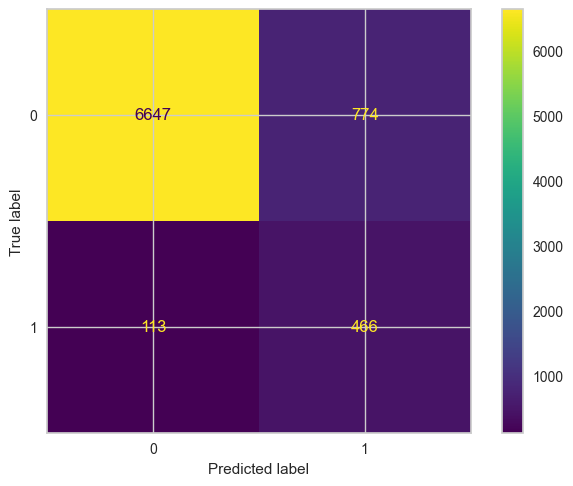

Total predictions for class 0:  6760
Total predictions for class 1:  1240


In [16]:
rfc = RandomForestClassifier(criterion = 'gini',max_depth = 9, n_estimators = 250, random_state=42)
rfc.fit(X_train_smote, y_train_smote)
rfc_pred = rfc.predict(X_test)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
print("AUC: ", roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))
rfc_scores = cross_val_score(rfc, X=X_train_smote, y=y_train_smote, scoring="accuracy", cv = 5, n_jobs=-3, verbose=0)
print("Average Accuracy of Random forest algorithm for 5 fold cross validation: ", rfc_scores.mean())

eval_results(y_test, rfc_pred, rfc)

We can acheive 92% accuracy with the random forest algorithm. While the model's recall is high, it lacks in precision as it has misclassified over 800 examples.

### 2. Extra Trees Classifier

Pycaret has determined this is the best model and its configuration is selected as defined by pycaret.

AUC:  0.9254937267833732
Average Accuracy of Random forest algorithm for 5 fold cross validation:  0.9788431808931313
F1 Score:  0.4476744186046512
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7421
           1       0.51      0.40      0.45       579

    accuracy                           0.93      8000
   macro avg       0.73      0.68      0.70      8000
weighted avg       0.92      0.93      0.92      8000



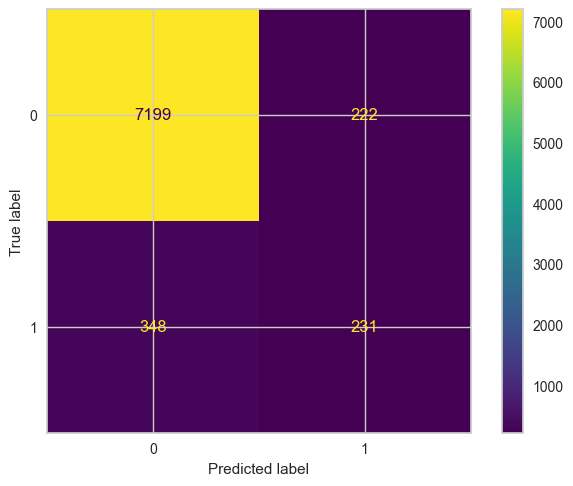

Total predictions for class 0:  7547
Total predictions for class 1:  453


In [17]:
et = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)

et.fit(X_train_smote, y_train_smote)
pred_et = et.predict(X_test)
fpr_et, tpr_et, thresholds_et = roc_curve(y_test, et.predict_proba(X_test)[:,1])

print("AUC: ", roc_auc_score(y_test, et.predict_proba(X_test)[:,1]))

et_scores = cross_val_score(et, X=X_train_smote, y=y_train_smote, scoring="accuracy", cv = 5, n_jobs=-3, verbose=0)
print("Average Accuracy of Random forest algorithm for 5 fold cross validation: ", et_scores.mean())

eval_results(y_test, pred_et, et)

We can acheive 97% accuracy with the extra trees classifier. However, this is not a good model as it lacks precision and recall. The model is biased towards class 0 and it it making large number of predictions for this class. The model makes mistakes in classifying the datapoints belonging to class 1.

### 3. XGBoost

[12:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

AUC:  0.9337954490815054
Average Accuracy of Random forest algorithm for 5 fold cross validation:  0.9363784489093708
F1 Score:  0.5376623376623377
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7421
           1       0.43      0.72      0.54       579

    accuracy                           0.91      8000
   macro avg       0.70      0.82      0.74      8000
weighted avg       0.94      0.91      0.92      8000



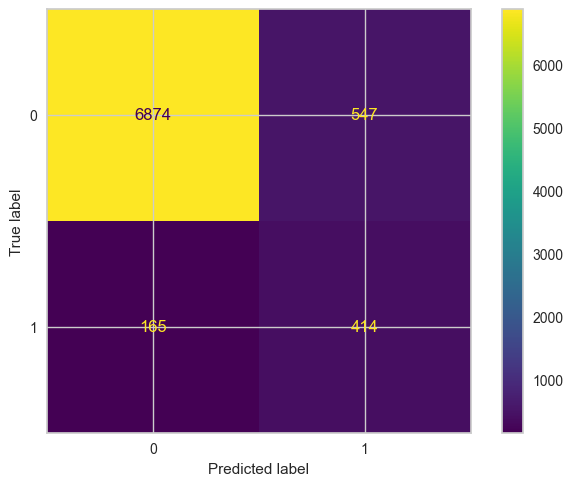

Total predictions for class 0:  7039
Total predictions for class 1:  961


In [18]:
xgb_model = xgboost.XGBClassifier(objective='binary:logistic',min_child_weight=10, subsample=0.35, colsample_bytree=0.35, max_depth=3, learning_rate=0.01, n_estimators=1000,silent=True, nthread=-3)
xgb_model.fit(X_train_smote, y_train_smote)

y_pred_xg = xgb_model.predict(X_test)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

print("AUC: ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))
      
xbg_scores = cross_val_score(xgb_model, X=X_train_smote, y=y_train_smote, scoring="accuracy", cv = 5, n_jobs=-3, verbose=0)
print("Average Accuracy of Random forest algorithm for 5 fold cross validation: ", xbg_scores.mean())

eval_results(y_test, y_pred_xg, xgb_model)

We can acheive 93% accuracy with XGBoost classifier. The model has better F1 score compared to previous models as it is prone to lesser misclassifications.

### 4. Logistic regression

Average Accuracy of Random forest algorithm for 5 fold cross validation:  0.8474548581720122
F1 Score:  0.4354688950789229
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7421
           1       0.30      0.81      0.44       579

    accuracy                           0.85      8000
   macro avg       0.64      0.83      0.67      8000
weighted avg       0.93      0.85      0.88      8000



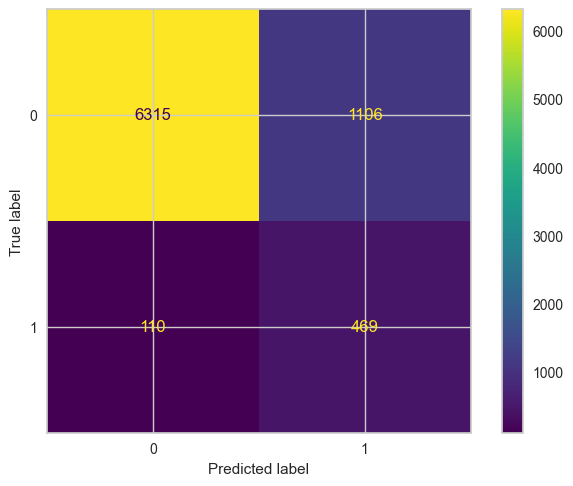

Total predictions for class 0:  6425
Total predictions for class 1:  1575


In [19]:
log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote)

y_pred_lg = log_reg.predict(X_test)

log_reg_scores = cross_val_score(log_reg, X=X_train_smote, y=y_train_smote, scoring="accuracy", cv = 5, n_jobs=-3, verbose=0)
print("Average Accuracy of Random forest algorithm for 5 fold cross validation: ", log_reg_scores.mean())

eval_results(y_test, y_pred_lg, log_reg)

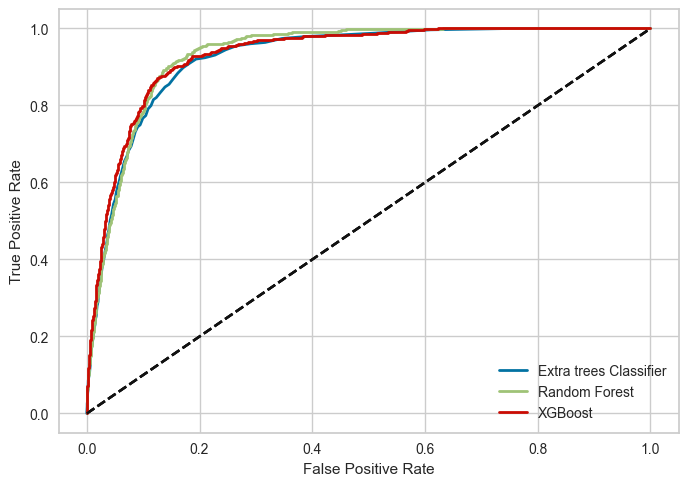

In [20]:
plot_roc_curve(fpr_et, tpr_et, label = "Extra trees Classifier")
plot_roc_curve(fpr_rfc, tpr_rfc, label = "Random Forest")
plot_roc_curve(fpr_xgb, tpr_xgb, label = "XGBoost")
plt.legend(loc="lower right")
plt.show()

The XGBoost model has good accuracy combined with good precision and recall in comparison to other models that we have tested. Extra Trees classifier model is prone to more misclassifications when compared with XGBoost model. The performance can be improved by performing more feature engineering on the features and additionally, adding more examples belonging to class 1 to the training data can improve the performance of the model/

**Note:** Since the data is imbalanced, accuracy is not a good metric to compare the models. It is important to understand how the model is performing on under represented classes in the dataset. Metrics such as recall, weighted F1 score might be good measures.